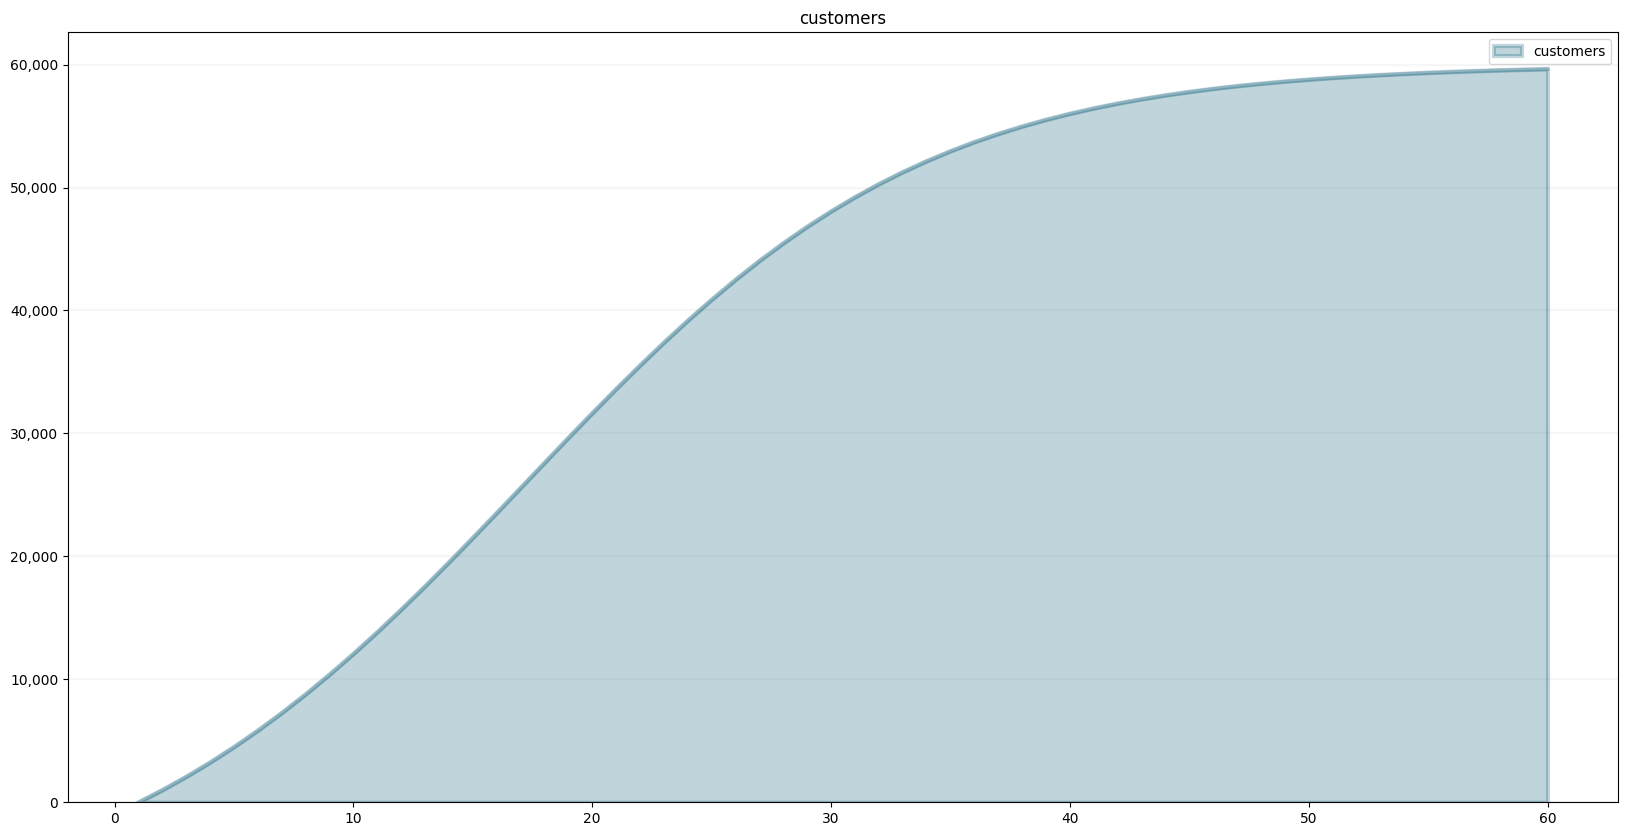

In [1]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd
model = Model(starttime=1.0,stoptime=60.0, dt=1.0, name="Customer Acquisition SDDSL")
# stocks
customers = model.stock("customers")
potential_customers = model.stock("potential_customers")
#flows
customer_acquisition=model.flow("customer_acquisition")
#converters
acquisition_through_advertising = model.converter("acquisition_through_advertising")
acquisition_through_word_of_mouth = model.converter("acquisition_through_word_of_mouth")
consumers_reached_through_advertising = model.converter("consumers_reached_through_advertising")
consumers_reached_through_word_of_mouth= model.converter("consumers_reached_through_word_of_mouth")
market_saturation = model.converter("market_saturation")
#constants
initial_customers = model.constant("initial_customers") 
initial_potential_customers = model.constant("initial_potential_customers") 
advertising_success = model.constant("advertising_success")
consumers_reached_per_euro = model.constant("consumers_reached_per_ruro")
advertising_budget = model.constant("advertising_budget")
word_of_mouth_success = model.constant("word_of_mouth_success")
contact_rate = model.constant("contact_rate")
#equations
customers.equation = customer_acquisition
potential_customers.equation = -customer_acquisition
customer_acquisition.equation=sd.min(potential_customers,acquisition_through_advertising+acquisition_through_word_of_mouth)
acquisition_through_advertising.equation = advertising_success*consumers_reached_through_advertising
consumers_reached_through_advertising.equation = consumers_reached_per_euro*advertising_budget*(1-market_saturation)
market_saturation.equation = customers/(customers+potential_customers)
acquisition_through_word_of_mouth.equation = word_of_mouth_success*consumers_reached_through_word_of_mouth
consumers_reached_through_word_of_mouth.equation=contact_rate*customers*(1-market_saturation)

#initialize model
customers.initial_value=initial_customers
potential_customers.initial_value=initial_potential_customers
initial_customers.equation = 0.0
initial_potential_customers.equation = 60000.0
advertising_success.equation = 0.1
consumers_reached_per_euro.equation = 100.0
advertising_budget.equation = 100.0
word_of_mouth_success.equation = 0.01
contact_rate.equation = 10.0

customers.plot()

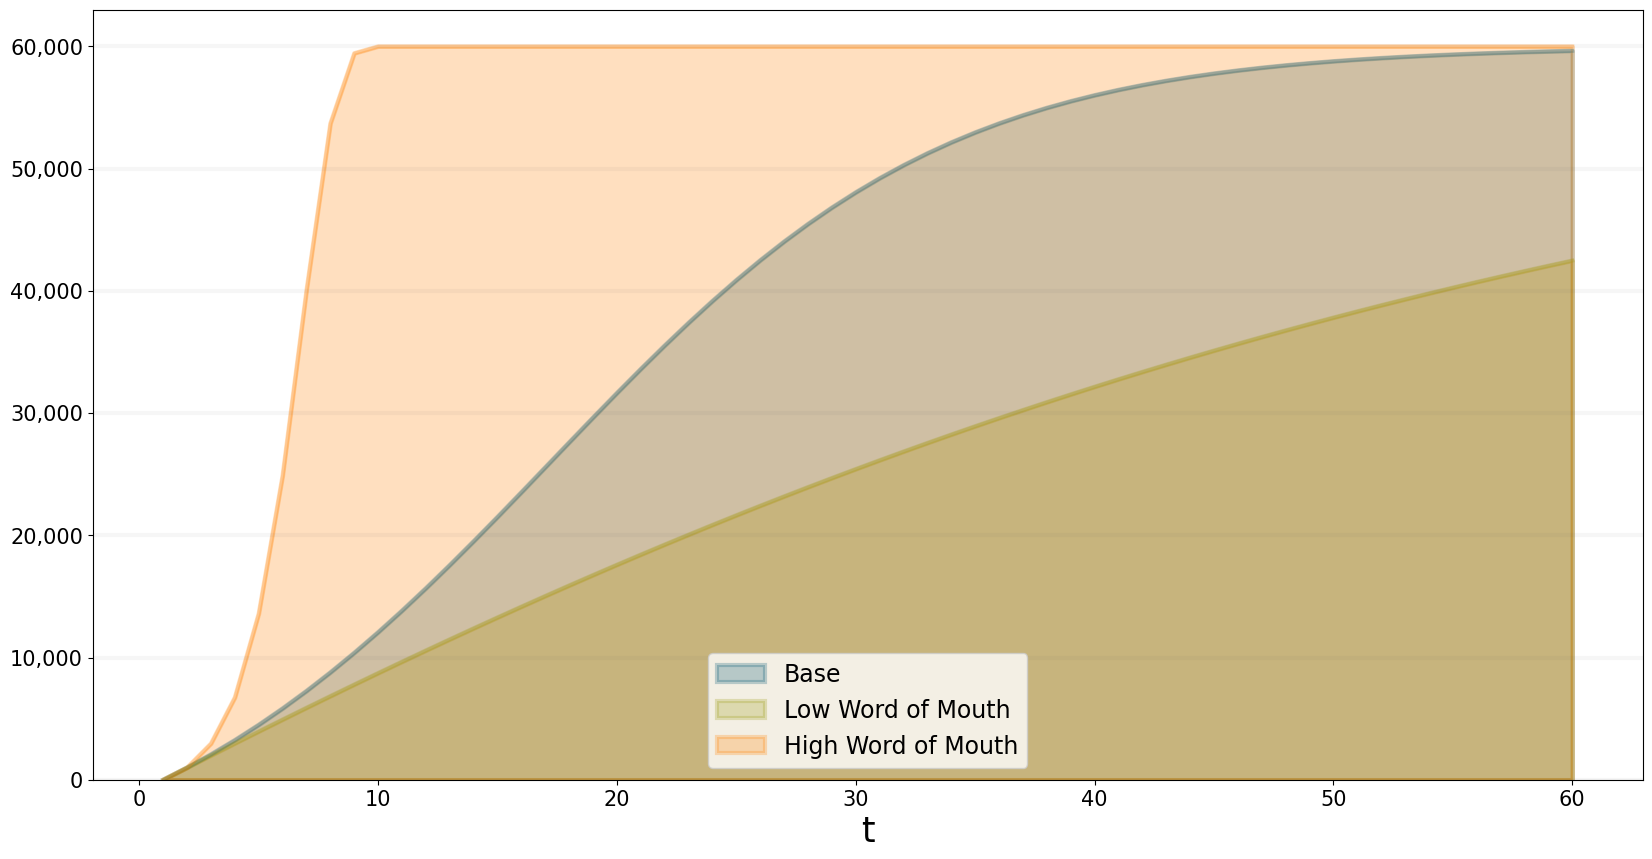

In [7]:
import BPTK_Py
bptk = BPTK_Py.bptk()

scenario_manager={
    "sddsl_customer_acquisition":{
        "model":model,
        "base_constants":{
            "initial_customers" : 0.0,
            "initial_potential_customers" : 60000.0,
            "advertising_success": 0.1,
            "consumers_reached_per_euro" : 100.0,
            "advertising_budget" : 100.0,
            "word_of_mouth_success": 0.01,
            "contact_rate" : 10.0
        }
    }
}


bptk.register_scenario_manager(scenario_manager)

bptk.register_scenarios(
    
    scenario_manager="sddsl_customer_acquisition",
    scenarios =
    {
        "base":{
            
        },
        "low_word_of_mouth":{
            "constants":{
                "word_of_mouth_success":0.001
            }
        },
        "high_word_of_mouth":{
            "constants":{
                "word_of_mouth_success":0.1
            }
        },
        "interactive_scenario":{}
        
    }
    

)

bptk.plot_scenarios(
    scenario_managers=["sddsl_customer_acquisition"],
    scenarios=["base","low_word_of_mouth","high_word_of_mouth"],
    equations=["customers"],
    series_names={
        "sddsl_customer_acquisition_base_customers":"Base",
        "sddsl_customer_acquisition_low_word_of_mouth_customers":"Low Word of Mouth",
        "sddsl_customer_acquisition_high_word_of_mouth_customers":"High Word of Mouth",
    }
)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

customerTab = widgets.Output()
customerAcquisitionTab = widgets.Output()
scenariosTab = widgets.Output()


tabs = widgets.Tab(children = [customerTab, customerAcquisitionTab,scenariosTab])
tabs.set_title(0, 'Customers')
tabs.set_title(1, 'Customer Acquisition')
tabs.set_title(2, 'Scenarios')
display(tabs)

@interact(word_of_mouth_success=widgets.FloatSlider(
    value=0.01,
    min=0.001,
    max=0.1,
    step=0.001,
    continuous_update=False,
    description='Word Of Mouth Success'
))
def dashboardWithTabs(word_of_mouth_success):
    scenario= bptk.get_scenario("sddsl_customer_acquisition","interactive_scenario")
    
    scenario.constants["word_of_mouth_success"]=word_of_mouth_success
    bptk.reset_scenario_cache(scenario_manager="sddsl_customer_acquisition",
                                                             scenario="interactive_scenario")



    with customerTab:
        # turn of pyplot's interactive mode to ensure the plot is not created directly
        plt.ioff()
        # clear the widgets output ... otherwise we will end up with a long list of plots, one for each change of settings
        customerTab.clear_output()
        # create the plot, but don't show it yet
        bptk.plot_scenarios(
            scenario_managers=["sddsl_customer_acquisition"],
            scenarios=["interactive_scenario"],
            equations=['customers'],
            title="Customers",
            freq="M",
            x_label="Time",
            y_label="No. of Customers"
            )
        # show the plot
        plt.show()
        # turn interactive mode on again
        plt.ion()

    with customerAcquisitionTab:
        plt.ioff()
        customerAcquisitionTab.clear_output()
        bptk.plot_scenarios(
            scenario_managers=["sddsl_customer_acquisition"],
            scenarios=["interactive_scenario"],
            equations=['customer_acquisition'],
            title="Customer Acquisition",
            freq="M",
            x_label="Time",
            y_label="No. of Customers"
            )
        plt.show()
        plt.ion()
    
    with scenariosTab:
        plt.ioff()
        scenariosTab.clear_output()
        bptk.plot_scenarios(
            scenario_managers=["sddsl_customer_acquisition"],
            scenarios=["base","low_word_of_mouth","high_word_of_mouth","interactive_scenario"],
            equations=["customers"],
            series_names={
                "sddsl_customer_acquisition_base_customers":"Base",
                "sddsl_customer_acquisition_interactive_scenario_customers":"Interactive",
                "sddsl_customer_acquisition_low_word_of_mouth_customers":"Low Word of Mouth",
                "sddsl_customer_acquisition_high_word_of_mouth_customers":"High Word of Mouth",
        })
        plt.show()
        plt.ion()

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='Word Of Mouth Success', ma…

In [ ]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd
from BPTK_Py import Agent
from BPTK_Py import Event
from BPTK_Py import DataCollector
from BPTK_Py import SimultaneousScheduler
import random
import math


DISEASE_PARAMS = {
    "alpha": 0.3,
    "gamma":0.6,
    "delta":0.7,
    "c0":1,
    "baseline_incidence":2e-3
}

APPLIANCE_CATALOG = {
    "electric_cooker": {
        "cost": 500,
        "monthly_kwh": 30,
        "beta_0": -3.5,
        "beta_income": 0.00003,
        "beta_reliability": 2.0,
        "beta_social": 1.0,
        "beta_cost": 0.003
    },
    "tv": {
        "cost": 300,
        "monthly_kwh": 5,
        "beta_0": -2.0,
        "beta_income": 0.00002,
        "beta_reliability": 0.5,
        "beta_social": 2.5,
        "beta_cost": 0.002
    },
    "electric_lighting": {
        "cost": 50,
        "monthly_kwh": 3,
        "beta_0": -4.5,
        "beta_income": 0.00004,
        "beta_reliability": 3.5,
        "beta_social": 3.8,
        "beta_cost": 0.0001
    }
}

FUEL_APPLIANCE_CATALOG = {
    "lpg_stove": {
        "hours_used": 2.5,
        "fuel_used_hour": 0.5,
        "cost_per_unit": 10, 
        "fuel_emission_factor_pm25": 15, #g/L
        "fuel_emission_factor_co2": 4.8,
        "kitchen_fraction": 0.25
    },
    "kerosene_lamp": {
        "hours_used": 5,
        "fuel_used_hour": 0.5,
        "cost_per_unit": 15, 
        "fuel_emission_factor_pm25": 10, #g/L
        "fuel_emission_factor_co2": 3.8,
        "kitchen_fraction": 0.3
    }
}

# --- Household Agent ---
class Household(Agent):
    def initialize(self):
        self.agent_type = "household"
        self.state = "unconnected"
        self.members = []
        if random.random() < 0.4:
            self.members.append({"role":"man","employed":random.random()<0.7,"income":0,"exposure":0,"exposure_fraction":0.450})
        if random.random() < 0.7:
            self.members.append({"role":"woman","employed":random.random()<0.25,"income":0,"exposure":0,"exposure_fraction":0.628})
        num_children = random.randint(0, 3)
        for _ in range(num_children):
            self.members.append({"role":"child","study_time":0,"human_capital":0.0,"income":0,"exposure":0,"exposure_fraction":0.742})

        self.fuel_appliances = {}  # name → owned (True/False)
        for name in FUEL_APPLIANCE_CATALOG:
            self.fuel_appliances[name] = True

        
        self.electric_appliances = {}  # name → owned (True/False)
        for name in APPLIANCE_CATALOG:
            self.electric_appliances[name] = False


    def electrify(self):
        self.state = "connected"

    def time_saved_men(self):
        if self.state == "connected":
            return 1   # hours/day saved
        return 0.0

    def time_saved_women(self):
        if self.state == "connected":
            return 2.5   # hours/day saved
        return 0.0
    

    def step(self,future_income_multiplier,available_jobs):
        saved_hours_men = self.time_saved_men()
        saved_hours_women = self.time_saved_women()
        if self.state == "connected":
            for m in self.members:
                if m["role"] in ["man","woman"] and m["employed"]:
                    m["income"] += 10 if m["role"]=="man" else 5
                elif m["role"]=="child":
                    m["study_time"] += 2
                    m["human_capital"] += 0.001 * m["study_time"]
                
            
        else:
            for m in self.members:
                if m["role"] in ["man","woman"] and m["employed"]:
                    m["income"] += 2 if m["role"]=="man" else 1
                elif m["role"]=="child":
                    m["study_time"] += 0.5
                    m["human_capital"] += 0.001 * m["study_time"]

        if self.state == "connected" and available_jobs > 0:
            for m in self.members:
                if m["role"] == "man":
                    if random.random() < 0.03:
                        m["employed"] = True
                        m["income"] += 8.0
                        available_jobs -= 1
                elif m["role"] == "woman":
                    if random.random() < 0.03:
                        m["employed"] = True
                        m["income"] += 5.0
                        available_jobs -= 1

        return available_jobs          


    def total_income(self):
        return sum(m.get("income",0) for m in self.members if m["role"] in ["man","woman"])

    def total_study_time(self):
        return sum(m.get("study_time",0) for m in self.members if m["role"]=="child")
        

    def consider_appliance_adoption(self, reliability, social_influence):
        income = self.total_income()

        for name, a in APPLIANCE_CATALOG.items():

            if self.electric_appliances[name]:
                continue  # already owned

            utility = (
                a["beta_0"]
                + a["beta_income"] * income
                + a["beta_reliability"] * reliability
                + a["beta_social"] * social_influence
                - a["beta_cost"] * a["cost"]
            )

            adoption_prob = 1 / (1 + math.exp(-utility))

            if random.random() < adoption_prob and name == "electric_cooker":
                self.electric_appliances[name] = True
                self.fuel_appliances["lpg_stove"] = False
            elif random.random() < adoption_prob and name == "electric_lighting":
                self.electric_appliances[name] = True
                self.fuel_appliances["kerosene_lamp"] = False
            elif random.random() < adoption_prob:
                self.electric_appliances[name] = True

    def fossil_fuel_use(self):
        total_fuel_use = 0.0
        for name, a in FUEL_APPLIANCE_CATALOG.items():

            if self.fuel_appliances[name]:
                fuel_use = a["hours_used"]*a["fuel_used_hour"] * 30
            else:
                fuel_use = 0.0
            total_fuel_use += fuel_use
        return total_fuel_use

    def energy_cost(self):
        total_fuel_cost = 0.0
        for name, a in FUEL_APPLIANCE_CATALOG.items():
            if self.fuel_appliances[name]:
                fuel_cost = a["hours_used"]*a["fuel_used_hour"]*a["cost_per_unit"] * 30
            else:
                fuel_cost = 0.0
                
            total_fuel_cost += fuel_cost
            
        total_electric_appliance_cost = 0.0
        for name, a in APPLIANCE_CATALOG.items():
            if self.electric_appliances[name]:
                electric_appliance_cost = a["monthly_kwh"] * 0.18
            else:
                electric_appliance_cost = 0.0
                
            total_electric_appliance_cost += electric_appliance_cost
        total_energy_cost = total_fuel_cost + total_electric_appliance_cost
        return total_energy_cost

    def baseline_fuel_cost(self):
        baseline_total_fuel_cost = 0.0
        for name, a in FUEL_APPLIANCE_CATALOG.items():
            baseline_fuel_cost = a["hours_used"]*a["fuel_used_hour"]*a["cost_per_unit"] * 30
            baseline_total_fuel_cost += baseline_fuel_cost
        return baseline_total_fuel_cost
        
    def co2_emissions(self):
        total_co2_emissions = 0.0
        for name, a in FUEL_APPLIANCE_CATALOG.items():
            if self.fuel_appliances[name]:
                co2_emissions = a["hours_used"]*a["fuel_used_hour"]*a["fuel_emission_factor_co2"] * 30
            else:
                co2_emissions = 0.0
        
            total_co2_emissions += co2_emissions
        return total_co2_emissions

    def pm25_concentration(self):
        air_change_rate_daily = 24.0 #air changes per day in the kitchen
        kitchen_volume = 20.0 # m^3
        outdoor_concentration = 1e-6

        weighted_fraction = 0.0
        total_emissions = 0.0

        for name, a in FUEL_APPLIANCE_CATALOG.items():
            if self.fuel_appliances[name]:
                emissions = a["hours_used"] * a["fuel_used_hour"] * a["fuel_emission_factor_pm25"]
                total_emissions += emissions
                weighted_fraction += emissions * a["kitchen_fraction"]

        if total_emissions > 0:
            frac = weighted_fraction / total_emissions
        else:
            frac = 0.0

        pm25_concentration = (total_emissions * frac) / (air_change_rate_daily * kitchen_volume) + outdoor_concentration
        
       # total_emissions = 0.0
       # for name, a in FUEL_APPLIANCE_CATALOG.items():
       #     if self.fuel_appliances[name]:
       #         pm25_emissions = a["hours_used"]*a["fuel_used_hour"]*a["fuel_emission_factor_pm25"]
       #         total_emissions +=pm25_emissions
       #     pm25_concentration = ((total_emissions * a["kitchen_fraction"]) / (air_change_rate_daily * kitchen_volume)) + outdoor_concentration
        return pm25_concentration

    def pm25_concentration_baseline(self):
        air_change_rate_daily = 24.0 #air changes per day in the kitchen
        kitchen_volume = 20.0 # m^3
        outdoor_concentration = 1e-6

        total_emissions_baseline = 0.0
        for name, a in FUEL_APPLIANCE_CATALOG.items():
            pm25_emissions_baseline = a["hours_used"]*a["fuel_used_hour"]*a["fuel_emission_factor_pm25"]
            total_emissions_baseline +=pm25_emissions_baseline
        pm25_concentration_baseline = ((total_emissions_baseline * a["kitchen_fraction"]) / (air_change_rate_daily * kitchen_volume)) + outdoor_concentration
        return pm25_concentration_baseline

    def baseline_cases(self):
        concentration_baseline = self.pm25_concentration_baseline()
        alpha = DISEASE_PARAMS["alpha"]
        gamma = DISEASE_PARAMS["gamma"]
        delta = DISEASE_PARAMS["delta"]
        c0 = DISEASE_PARAMS["c0"]
        baseline_incidence = DISEASE_PARAMS["baseline_incidence"] # number of cases per month
        total_cases_baseline =0.0
        for member in self.members:
            baseline_exposure = member["exposure_fraction"]*concentration_baseline*1e6 # the individual exposure is a fraction of the concentration in the house. Scaled from g/m3 to ug/m3
            excess = max(0.0, baseline_exposure - c0)
            RR_baseline = 1 + alpha * (1 - math.exp(-gamma * (excess ** delta))) # Relative risk
            PAF_baseline = (RR_baseline - 1) / RR_baseline # Attributable fraction
            attributable_cases_baseline = PAF_baseline * baseline_incidence * len(self.members)
            total_cases_baseline += attributable_cases_baseline
        return total_cases_baseline
        
    def cases(self):
        concentration = self.pm25_concentration()
        alpha = DISEASE_PARAMS["alpha"]
        gamma = DISEASE_PARAMS["gamma"]
        delta = DISEASE_PARAMS["delta"]
        c0 = DISEASE_PARAMS["c0"]
        baseline_incidence = DISEASE_PARAMS["baseline_incidence"] # number of cases per month
        total_cases = 0.0
        for member in self.members:
            member["exposure"] = member["exposure_fraction"]*concentration*1e6 # the individual exposure is a fraction of the concentration in the house. Scaled from g/m3 to ug/m3
            excess = max(0.0, member["exposure"] - c0)
            RR = 1 + alpha * (1 - math.exp(-gamma * (excess ** delta)))# Relative risk
            PAF = (RR - 1) / RR # Attributable fraction
            attributable_cases = PAF * baseline_incidence * len(self.members)
            total_cases += attributable_cases

        return total_cases
         
        
                
    def appliance_demand(self):
        demand = 0.0
        for name, owned in self.electric_appliances.items():
            if owned:
                demand += APPLIANCE_CATALOG[name]["monthly_kwh"]
        return demand


# --- System Dynamics Model ---
class ElectrificationSD:
    def __init__(self, model):
        self.model = model

        # Stocks
        self.households_connected = model.stock("households_connected")
        self.households_not_connected = model.stock("households_not_connected")
        self.net_microgrid_income = model.stock("net_microgrid_income")
        self.no_of_failures = model.stock("no_of_failures")
        self.no_of_components = model.stock("no_of_components")
        self.no_of_current_repairs = model.stock("no_of_current_repairs")
        self.available_jobs = model.stock("available_jobs")
        
        
        # Flows     
        self.connection_flow = model.flow("connection_flow")
        self.household_microgrid_adoption = model.flow("household_microgrid_adoption")
        self.microgrid_income = model.flow("microgrid_income")
        self.microgrid_expenditures = model.flow("microgrid_expenditures")
        self.microgrid_income_flow = model.flow("microgrid_income_flow")
        self.failure_rate = model.flow("failure_rate")
        self.fixture_rate = model.flow("fixture_rate")
        self.job_creation = model.flow("job_creation")
        self.job_attrition = model.flow("job_attrition")
        

        # Converters
        self.power_use = model.converter("power_use")
        self.failure_rate_multiplier =  model.converter("failure_rate_multiplier")
        self.mttr = model.converter("mttr")
        self.saifi = model.converter("saifi")
        self.saidi = model.converter("saidi")
        self.no_of_customers = model.converter("no_of_customers")
        self.downtime = model.converter("downtime")
        self.reliability = model.converter("reliability")
        self.social_influence_microgrid = model.converter("social_influence_microgrid")
        self.baseline_demand = model.converter("baseline_demand")
        self.total_demand = model.converter("total_demand")
        self.cost_savings = model.converter("cost_savings")
        self.total_energy_cost = model.converter("energy_cost")
        self.baseline_fuel_cost = model.converter("baseline_fuel_cost")

        self.total_cases = model.converter("total_cases")        
        self.baseline_cases = model.converter("baseline_cases")
        self.health_improvements = model.converter("health_improvements")

       # self.human_capital = model.converter("human_capital")
        self.future_income_multiplier = model.converter("future_income_multiplier")
        self.employment = model.converter("employment")
        self.business_income = model.converter("business_income")
        self.capital_investment = model.converter("capital_investment")
        
        self.tariff = model.converter("tariff")
        self.subsidy = model.converter("subsidy")

        # Aggregate social/economic converters
        self.avg_income = model.converter("avg_income")
        self.avg_study_time = model.converter("avg_study_time")
        self.appliance_demand = model.converter("appliance_demand")

        self.baseline_household_demand = model.constant("baseline_household_demand")
        self.no_of_households = model.constant("no_of_households")
        self.microgrid_capacity = model.constant("microgrid_capacity")
        self.initial_failure_rate = model.constant("initial_failure_rate")
        self.cost_per_kwh = model.constant("cost_per_kwh")
        self.no_of_components_initial_value = model.constant("no_of_components_initial_value")
        self.attrition_rate = model.constant("attrition_rate")
        self.mpc = model.constant("mpc")
        self.local_spending_fraction = model.constant("local_spending_fraction")
        self.investment_rate = model.constant("investment_rate")
        self.job_creation_efficiency = model.constant("job_creation_efficiency")

        # Equations
        self.social_influence_microgrid.equation = self.households_connected/self.no_of_households
        self.household_microgrid_adoption.equation = self.households_not_connected * ((1e-2 * self.reliability) + (0.1e-2*self.social_influence_microgrid) + (3e-3*self.cost_savings)+(5e-2*self.health_improvements))#
        self.households_connected.equation = self.household_microgrid_adoption
        self.households_not_connected.equation = -self.household_microgrid_adoption
        self.baseline_demand.equation = ((self.baseline_household_demand) * self.households_connected)
        self.total_demand.equation = self.baseline_demand+self.appliance_demand
        self.power_use.equation = sd.min(self.total_demand,self.microgrid_capacity)
        self.microgrid_income_flow.equation = self.power_use * self.cost_per_kwh
        self.net_microgrid_income.equation = self.microgrid_income_flow
        self.mttr.equation = sd.lookup(
            self.net_microgrid_income,
            [(0, 48), (30000000, 42), (70000000, 36), (100000000, 30)]
        )

        self.failure_rate_multiplier.equation = sd.lookup(
            self.power_use,
            [(90000, 1), (100000, 3), (115000, 6), (130000, 8)]
        )
        self.failure_rate.equation = self.initial_failure_rate*self.no_of_components*self.failure_rate_multiplier
        self.no_of_failures.equation = self.failure_rate
        self.fixture_rate.equation = self.no_of_current_repairs/self.mttr
        #number of components stock
        self.no_of_components.equation = self.fixture_rate - self.failure_rate
        #number of components being repaired
        self.no_of_current_repairs.equation = self.failure_rate - self.fixture_rate
        # Failure rate depends on maintenance delay
        self.downtime.equation = self.mttr * self.no_of_failures
        # SAIDI (interruptions per customer)
        self.saidi.equation = self.downtime / sd.max(1, self.households_connected)
        # SAIFI (interruptions per customer)
        self.saifi.equation = self.no_of_failures / sd.max(1, self.households_connected)
        # Reliability improves as SAIDI decreases
        self.reliability.equation = 1/(1+4.83*self.saidi)

        self.cost_savings.equation = 1 - (self.total_energy_cost/self.baseline_fuel_cost)
        self.health_improvements.equation = 1 - (self.total_cases/self.baseline_cases)


        # R4: Income → spending → investment → jobs
        self.business_income.equation = self.mpc * self.local_spending_fraction * self.avg_income
        self.capital_investment.equation = self.investment_rate * self.business_income
        self.job_creation.equation = self.job_creation_efficiency * self.capital_investment
        self.job_attrition.equation = self.attrition_rate * self.available_jobs
        self.available_jobs.equation = self.job_creation - self.job_attrition

        # R5: Education → human capital → future income
        self.future_income_multiplier.equation = 1 + 0.002 * self.avg_study_time

        # These will be updated dynamically from agents in begin_round
        
        #self.avg_income.equation = avg_income
        #self.avg_study_time.equation = avg_study #please work
        #self.appliance_demand.equation = appliance_demand
        #self.total_energy_cost.equation = total_energy_cost
        #self.baseline_fuel_cost.equation = baseline_fuel_cost
        #self.total_cases.equation = total_cases
       
        

        # Initial values
        self.no_of_households.equation = 600.0
        self.households_connected.initial_value = 0.0 
        self.households_not_connected.initial_value = self.no_of_households
        self.microgrid_capacity.equation = 1000000.0 #KW
        self.cost_per_kwh.equation = 0.18
        self.initial_failure_rate.equation = (6e-6)*720.0
        self.no_of_failures.initial_value = 0.0
        self.no_of_components_initial_value.equation = 2.0
        self.no_of_components.initial_value = self.no_of_components_initial_value
        self.no_of_current_repairs.initial_value = 0.0
        self.baseline_household_demand.equation = 200.0 #in kWh

        self.mpc.equation = 0.75
        self.local_spending_fraction.equation = 0.6
        self.investment_rate.equation = 0.25
        self.job_creation_efficiency.equation = 0.05
        self.attrition_rate.equation = 0.02


# --- Hybrid Model ---
class ElectrificationHybrid(Model):
    def instantiate_model(self):
        super().instantiate_model()
        self.register_agent_factory("household", lambda agent_id, model, properties: Household(agent_id, model, properties))
        self.sd_model = ElectrificationSD(self)

    def configure(self, config):
        super().configure(config)
        #self.sd_model.reliability.equation = self.reliability
        self.sd_model.tariff.equation = self.tariff
        self.sd_model.subsidy.equation = self.subsidy

        self.sd_model.no_of_households.equation = self.no_of_households
        self.sd_model.microgrid_capacity.equation = self.microgrid_capacity
        self.sd_model.cost_per_kwh.equation = self.cost_per_kwh
        self.sd_model.initial_failure_rate.equation = self.initial_failure_rate
        self.sd_model.no_of_components_initial_value.equation = self.no_of_components_initial_value
        self.sd_model.baseline_household_demand.equation = self.baseline_household_demand
        #self.sd_model.future_income_multiplier.equation = self.future_income_multiplier

    def begin_round(self, time, sim_round, step):
        # Update agent states
        # begin_round
        future_income_multiplier = self.sd_model.future_income_multiplier(time)
        available_jobs = int(self.sd_model.available_jobs(time))

        reliability = self.sd_model.reliability(time)
        social_influence = self.sd_model.social_influence_microgrid(time)
        if time == self.starttime:
                baseline_cases = sum(h.baseline_cases() for h in self.agents)
                self.sd_model.baseline_cases.equation = baseline_cases
        for h in self.agents:
            
            available_jobs = h.step(future_income_multiplier,available_jobs)
            
            if h.state == "connected":
                h.consider_appliance_adoption(reliability, social_influence)
                

        # Aggregate outcomes from agents
        avg_income = sum(h.total_income() for h in self.agents) / len(self.agents)
        avg_study = sum(h.total_study_time() for h in self.agents) / len(self.agents)
        appliance_demand = sum(h.appliance_demand() for h in self.agents)
        baseline_fuel_cost = sum(h.baseline_fuel_cost () for h in self.agents)
        
        total_energy_cost = sum(h.energy_cost() for h in self.agents)
        baseline_fuel_cost = sum(h.baseline_fuel_cost() for h in self.agents)
        co2_emissions = sum(h.co2_emissions() for h in self.agents)
        total_cases = sum(h.cases() for h in self.agents)
        
        # Feed back into SD converters
        self.sd_model.avg_income.equation = avg_income
        self.sd_model.avg_study_time.equation = avg_study
        self.sd_model.appliance_demand.equation = appliance_demand
        self.sd_model.total_energy_cost.equation = total_energy_cost
        self.sd_model.baseline_fuel_cost.equation = baseline_fuel_cost
        self.sd_model.total_cases.equation = total_cases
        

        available_jobs = int(self.sd_model.available_jobs(time))

        unemployed = [
            m for h in self.agents
            for m in h.members
            if m["role"] in ["man","woman"] and not m["employed"]
        ]

        for m in unemployed[:available_jobs]:
            m["employed"] = True

        employment = sum(
        1 for h in self.agents
        for m in h.members
        if m["role"] in ["man","woman"] and m["employed"]
        )

        self.sd_model.employment.equation = employment

        # Electrification decision based on SD reliability
        #print(available_jobs)
        #print(self.sd_model.baseline_cases(time),self.sd_model.total_cases(time))
        required_connected = int(self.sd_model.households_connected(time))
        current_connected = len([a for a in self.agents if a.state == "connected"])
        households_to_connect = required_connected - current_connected
        for h in self.agents:
            if households_to_connect <= 0:
                break
            if h.state == "unconnected":
                h.electrify()
                households_to_connect -= 1

        connected_count = sum(1 for a in self.agents if a.state == "connected")
        print(f"Number of connected households: {connected_count}")


# --- Simulation Setup ---
electrification_hybrid = ElectrificationHybrid(
    1, 120, dt=1, name="Electrification Hybrid",
    scheduler=SimultaneousScheduler(),
    data_collector=DataCollector()

)

electrification_hybrid.instantiate_model()

electrification_config = {
    "runspecs": {
        "starttime": 1,
        "stoptime": 120,
        "dt": 1.0
    },
    "properties": {
        #"reliability": {"type": "Double", "value": 0.9},
        "tariff": {"type": "Double", "value": 10.0},
        "subsidy": {"type": "Double", "value": 0.0},
        "no_of_households": {"type": "Double", "value": 600.0},
        "microgrid_capacity": {"type": "Double", "value": 1000000.0},#KW
        "cost_per_kwh": {"type": "Double", "value": 0.18},
        "initial_failure_rate": {"type": "Double", "value": (6e-6)*720.0},
        "no_of_components_initial_value": {"type": "Double", "value": 2.0},
        "baseline_household_demand": {"type": "Double", "value": 200.0}#KW
        
    },
    "agents": [
        {"name": "household", "count": 600}
    ]
}

electrification_hybrid.configure(electrification_config)
electrification_hybrid.run()
[electrification_hybrid.statistics().get(1.0*key) for key in range(2,10)]
